In [1]:
import numpy as np
import h5py as h5
import scipy as sp
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy.random as rand

import ML_func_defs as ML
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from copy import deepcopy

/home/LoganTheKid/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Prove 06, 07, and 08

## Class net definition

In [2]:
class net():
    def __init__(self,train_data, target_data, num_lay, num_nodes, update_type='batch',
             g='sigmoid', plot_figs=False, momentum=False, momentum_alpha=.9,
             max_it=100**10,eta_0=.1,eta_decay=False, eta_half_life=10000,
             regression=False):
        self.train_data = train_data
        self.target     = target_data
        self.input_dim  = len(train_data[0])-1
        self.output_dim = len( set( list( target_data.flat ) ) )
        self.num_lay    = num_lay
        self.num_nodes  = num_nodes
        
        self.update_type = update_type            
        self.g_function = g
    
        self.regression = regression
        if regression:
            self.output_dim = 1
        
        self.init_weights() 
        self.momentum   = momentum
        self.momentum_a = momentum_alpha
        self.momentum_w = [np.zeros(( w.shape[0],w.shape[1] )) for w in self.weights ]
        self.max_it     = max_it
        self.plot_figs  = plot_figs
        self.train_acc, self.train_err = [], []
        self.val_acc  , self.val_err   = [], []
        self.eta        = eta_0
        self.eta_0      = eta_0
        self.eta_decay  = eta_decay
        self.eta_decay_rate = self.get_half_life( eta_half_life )
        
        
    def g_func(self, h):
        if self.g_function == 'sigmoid':
            return (1 + np.exp(-h))**-1.
        elif self.g_function == 'tanh':
            return np.tanh(h)
        else:
            return 'whoopsies: self.g_func()'

    def g_prime(self, h):
        if self.g_function == 'sigmoid':
            return self.g_func(h) * ( 1 - self.g_func(h) )
        elif self.g_function == 'tanh':
            return ( np.sech(h) )**2.
        else:
            return 'whoopsies: self.g_prime()'
    
    def init_weights(self):
        BI_NODE = 1
        self.weights = []
        for i in np.arange(self.num_lay+1):
            if i == 0:
                self.weights.append(rand.normal( loc=0.0, scale=0.15,
                               size=(self.num_nodes[i], self.input_dim+BI_NODE)))
            else:
                self.weights.append(rand.normal(loc=0.0,scale=0.15,
                               size=(self.num_nodes[i], self.num_nodes[i-1]+BI_NODE)))

    def stack_and_trans(self, var):
        new_var = var[0]
        for i in np.arange(1, len(var)):
            new_var = np.vstack(( new_var, var[i] ))
        return np.transpose( new_var )

    def add_bias(self, var):
        if var[0].ndim == 0:
            tmp_var = np.zeros(( len(var), 2 )) - 1
        else:
            tmp_var = np.zeros(( len(var), len(var[0])+1 )) - 1
        tmp_var[:,:-1] = var
        return tmp_var
        
    def forward_prop(self, data):
        h_temp = [ np.dot( data,self.weights[0][x]) \
                           for x in np.arange(len(self.weights[0]))]
        h = self.stack_and_trans(h_temp)
        
        a_temp = [ self.g_func(h) for x in range(len(h))]
        a_lst  = [ self.add_bias( a_temp[0] ) ]

        # loop though all the weights (except the first layer)
        for i,ws in enumerate(self.weights[1:]):
            # get h's for the next layer
            h = self.stack_and_trans( np.array([ np.dot(a_lst[-1],ws[x]) \
                                                 for x in range(len(ws)) ]) )
            # gets the next layer's a's
            a_temp = np.array([self.g_func(h[x]) for x in range(len(h))])
            
            
            # logic to make sure the output layer doesn't have a bias node
            if i == self.num_lay - 1:
                # if it's a regression problem get a linear output
                if self.regression:
                    a_temp = np.array(sum(h))                    
                a_lst.append( a_temp )
            else:
                # adds the bias node
                a_lst.append( self.add_bias( a_temp ) )
                
        return a_lst

    
    def get_deltas(self, targ, a):
        # reverse the weights and a's
        rev_w = self.weights[::-1]
        rev_a = a[::-1]

        # handle the output layer first because it's a different equation
        output_delta = np.array( rev_a[0] * (1-rev_a[0]) * (rev_a[0]-targ) )
        # This handles the case if there's only one output node. 
        if output_delta.ndim == 1:
            output_delta = np.array([np.array([d]) for d in output_delta])
        # deltas currently has dimensionality 1 x (N x M) where N is the 
        #        number of data entries in the training set and M is the
        #        number of output nodes.
        deltas = [ output_delta ]

        for j in np.arange(1, len(rev_w)):
            i = j - 1
            # delete the bias weights because they don't effect the next deltas
            # Note: w_nobi has dimensionality (AxB) where A is the number of 
            #       nodes in layer i and B is the number of nodes in layer j.
            w_nobi = np.delete(rev_w[i], len(rev_w[i])-1, 1) 

            # w_nobi is set up so that the colmuns correlate to a node 
            #     from layer j - and a row correlates to all the entries to a
            #     node in layer k. But we want all the weights that leave a 
            #     node in layer j, so it needs to be transposed.
            w_tr   = np.transpose( w_nobi )

            # delete the bias activations because they don't effect 
            #        the next deltas.
            a_nobi = np.delete(rev_a[j], len(rev_a[j][0])-1, 1)
            a_part = a_nobi * (1 - a_nobi)

            # make a temporary delta
            delta_t = deltas[-1]
            #handles the case that there is only one node by putting delta_t
            #        into the right format.  
            if delta_t.ndim == 1:
                delta_t = np.array([np.array([d]) for d in delta_t])
                
            # Get the sum of the deltas from layer k and the weights that connect 
            #     layer k to j. Currently the rows of delta_part correlate to the.
            delta_part = np.array( [ np.dot(delta_t,w_tr[x]) for x in range(len(w_tr))] )

            new_delta = np.array( a_part * np.transpose( delta_part ) ) 
            deltas.append( new_delta )

        return deltas[::-1]
    
    
    def weight_update(self, data, targ, a):
        wts = deepcopy( self.weights )
        deltas = self.get_deltas( targ, a )
        change_w = [ np.zeros(( w.shape[0],w.shape[1] )) for w in self.weights ]
        a.insert(0, data)

        for j,w in enumerate(self.weights):
            if self.update_type == 'batch':
                if self.momentum:
                        self.momentum_w[j] += self.momentum_a * change_w[j]                      
                for x,a1 in enumerate( a[j] ):
                    # Note: a1 has dimentionality (AxB) where A is the length of
                    #       training data set and B is the number of nodes in
                    #       layer i.
                    a1, delta = np.array( a1 ), np.array( deltas[j][x] )
                    del_X_a = np.array([ a1*delt for delt in delta ])
                    change_w[j] -= self.eta * del_X_a  
            elif self.update_type == 'sequential':
                if self.momentum:
                        self.momentum_w[j] += self.momentum_a * change_w[j]  
                        
                a1, delta = np.array( a[j].flat ), np.array( deltas[j].flat )
                del_X_a = np.array([ a1*delt for delt in delta ])
                change_w[j] -= self.eta * del_X_a
            else:
                print("ERROR - weight_update(): ")
                print("        update_type must be batch or sequential.")
                return 0
            
            wts[j] += change_w[j] + self.momentum_w[j]
        return wts
    
    def stop_criteria(self, count, val_err):
        if count < 1500:
            # Too soon to stop
            return True
        elif sum(val_err[-4:-2]) > sum(val_err[-2:]):
            # Continue so long as the average validation continues to go down
            return True
        else:
            # stops learning
            return False
        
    
    def get_accuracy(self, data, targs):
        if self.regression:
            # gets the Mean Absolute Percent Error for regression problems
            acc = len(data)**-1 * np.sum(np.array([ (t-data[x])/t for x,t in enumerate(targs)]) )
        else:
            pred      = np.zeros(( len(data), len(targs[0]) ))
            # the [-1] grabs just the output layer
            output    = self.forward_prop( data )[-1] 
            pred_args = np.argmax( output, axis=1 )

            corr_cnt = 0
            for i in np.arange( len(pred) ):
                pred[i, pred_args[i]] = 1  # make the prediction array
                if np.argmax(pred[i]) == np.argmax(targs[i]):
                    corr_cnt += 1 
            acc = corr_cnt/len( pred )
        
        return acc
    
    def get_error(self, data, targs):
        output = self.forward_prop( data )[-1]
        if self.regression:
            return .5 * np.sum( (output - targs)**2 )
        else:
            prediction = np.zeros(( len(data), len(targs[0]) )) 
            pred_arg   = np.argmax( output, axis=1 )
            for i in np.arange( len(prediction) ):
                prediction[i, pred_arg[i]] = 1

            return .5 * np.sum( (prediction - targs)**2 )
    
    def plot_one_fig(self, data, name, color='b'):
        plt.figure(name)
        plt.plot(data, color)
        plt.title(name)
        plt.show()
        
    def plot_figures(self, datas, names, colors=['o','b','g','k']):
        fig, axs = plt.subplots(nrows=2, ncols=2)
        ax = axs.flatten()
        for i in range(4):
            ax[i].plot(datas[i], colors[i])
            ax[i].set_title(names[i])
        fig.subplots_adjust(left=0.2, hspace=0.4, wspace=.3)

    def eta_decay_func(self, count):
        return self.eta_0 * np.exp( - self.eta_decay_rate * count )
    
    def get_half_life(self, count):
        return - np.exp( .5 ) * count**-1.
            
    def Test(self, test_data, test_targs):
        acc = self.get_accuracy(test_data, test_targs)
        err = self.get_error(   test_data, test_targs)
        print("\nFor the Test set:")
        print("The error =",err,"    And the accuracy =",acc)
    
    def train_net(self, val_data, val_test):
        a0, count= 0, 1

        while self.stop_criteria(count,self.val_err) and (count < self.max_it): 
            
            if self.update_type == 'batch':            
                a = self.forward_prop( self.train_data )
                self.weights = self.weight_update(self.train_data, self.target, a)
            elif self.update_type == 'sequential':
                for x,d in enumerate(self.train_data):
                    a = self.forward_prop( d )
                    self.weights = self.weight_update(d, self.target[x], a)
            else:
                print("ERROR: update_type must be batch or sequential.")
                return 0
            
            if count % 50 == 0:
                self.val_acc.append( self.get_accuracy(val_data, val_test) )
                self.val_err.append( self.get_error(val_data, val_test) )
                self.train_err.append( self.get_error(self.train_data, self.target) )
                self.train_acc.append(self.get_accuracy(self.train_data,self.target))
                
                if count % 1000 == 0:
                    print("Iteration ",count,"  Train accuracy =",self.train_acc[-1])
                    a1 = a[0]
                    print("normed difference of the activation =",np.linalg.norm(a1-a0))
                    a0 = a[0]
            
            if self.eta_decay:
                self.eta = self.eta_decay_func( count )
            count += 1
        
        if self.plot_figs:
            data = [self.val_err, self.val_acc, self.train_err, self.train_acc]
            name = ["Validation Set Error", "Validation Set Accuracy",\
                    "Training Set Error", "Training Set Accuracy" ]
            colors = ['orange', 'green', 'blue', 'k']
            self.plot_figures(data, name, colors=colors)
            #self.plot_one_fig(self.val_err, "Validation Set Error", color='orange')
            #self.plot_one_fig(self.val_acc, "Validation Set Accuracy", color='green')
            #self.plot_one_fig(self.train_err, "Training Set Error", color='blue')
            #self.plot_one_fig(self.train_acc, "Training Set Accuracy", color='k')

## Classification Probs

### Balance Data

How many hidden layers do you want (must be an integer)? 1
How many nodes in hidden layer  1 ? 
3
Iteration  1000   Train accuracy = 0.9275
normed difference of the activation = 20.0

For the Test set:
The error = 15.0     And the accuracy = 0.88


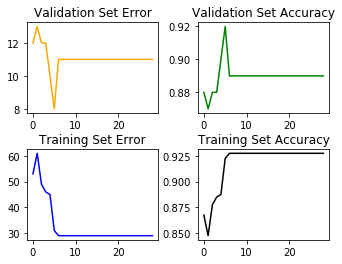

In [3]:
########################
#### GET THE LAYER INFO
DATA_OUTPUT_DIM = 3
num_lay = int( input("How many hidden layers do you want (must be an integer)? ") )

num_nodes = [ ]
for i in np.linspace(1, num_lay, num_lay):
    print("How many nodes in hidden layer ",int(i),"? ")
    num_nodes.append(int( input() ) )
num_nodes.append( DATA_OUTPUT_DIM )
#########################
#### GET THE BALANCE DATA
b_data = open("balance_scale.txt","rt")
contents = b_data.readlines()
b_data.close()

# Turns the string version of the data into floats in a 150x4 array
bal_data = np.array([[float(x.split(',')[1]),
                      float(x.split(',')[2]),
                      float(x.split(',')[3]),
                      float((x.split(',')[4]).split('\n')[0])] for x in contents])

## gets the iris names in stings 'setosa', 'versicolor', and 'virginica'
bal_target = [ x.split(',')[0] for x in contents ]
## dictionary to make recasting iris names intointegers easy
targ_vals = {'L':0, 'B':1, 'R':2}
## loop to recasting iris names into integers
for i,name in enumerate(bal_target):
    bal_target[i] = targ_vals[name]
    
###########################
#### SET UP THE NORMED DATA
norm_data = preprocessing.normalize(bal_data)
data = np.zeros(( len(norm_data), len(norm_data[0])+1 )) - 1
data[:,:-1] = norm_data

X_train, X_test, y_train, y_test = train_test_split(norm_data, bal_target, 
                                    test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                    test_size=0.2, random_state=1)

def process_targets(target):
    new_targ = np.zeros(( len(target), 3 ))
    for i in np.arange( len(target) ):
        t = target[i]
        new_targ[i,t] = 1
    return new_targ

y_train = process_targets( y_train )
y_val   = process_targets( y_val   )
y_test  = process_targets( y_test  )

Net = net(X_train, y_train, num_lay, num_nodes,update_type='batch',\
          momentum=True,plot_figs=True, max_it=10000)
#Net = net(X_train, y_train, num_lay, num_nodes,update_type='batch',\
#           plot_figs=True,eta_decay=True)
#Net = net(X_train, y_train, num_lay, num_nodes,update_type='sequential',\
#           plot_figs=True, eta_decay=True)
#Net = net(X_train, y_train, num_lay, num_nodes,update_type='sequential',\
#          momentum=True,plot_figs=True)
Net.train_net(X_val, y_val)
Net.Test(X_test, y_test)

### Iris Data

In [ ]:
DATA_OUTPUT_DIM = 3
num_lay = int( input("How many hidden layers do you want (must be an integer)? ") )

num_nodes = [ ]
for i in np.linspace(1, num_lay, num_lay):
    print("How many nodes in hidden layer ",int(i),"? ")
    num_nodes.append(int( input() ) )
num_nodes.append( DATA_OUTPUT_DIM )

iris      = datasets.load_iris()
targs     = iris.target
norm_data = preprocessing.normalize(iris.data)

data = np.zeros(( len(norm_data), len(norm_data[0])+1 )) - 1
data[:,:-1] = norm_data

X_train, X_test, y_train, y_test = train_test_split(norm_data, targs, 
                                    test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                    test_size=0.2, random_state=1)

def process_iris_targets(target):
    new_targ = np.zeros(( len(target), 3 ))
    for i in np.arange( len(target) ):
        t = target[i]
        new_targ[i,t] = 1
    return new_targ

y_train = process_iris_targets( y_train )
y_val   = process_iris_targets( y_val   )
y_test  = process_iris_targets( y_test  )

Net = net(X_train, y_train, num_lay, num_nodes,update_type='batch',\
          momentum=True,plot_figs=True, max_it=10000)
#Net = net(X_train, y_train, num_lay, num_nodes,update_type='batch',\
#           plot_figs=True,eta_decay=True)
#Net = net(X_train, y_train, num_lay, num_nodes,update_type='sequential',\
#           plot_figs=True, eta_decay=True)
#Net = net(X_train, y_train, num_lay, num_nodes,update_type='sequential',\
#          momentum=True,plot_figs=True)
Net.train_net(X_val, y_val)
Net.Test(X_test, y_test)

## Regressioni Problems

### Car Data

In [ ]:
gross_file = open('auto-mpd.txt','r')
ugly_lines = gross_file.readlines()

mpg, cylinders, displacement, horsepower, weight = [], [], [], [], []
acceleration, model_year, origin, car_name = [], [], [], []

for lin in ugly_lines:
    # The if gets rid of missing data now
    if lin.split('      ')[1] != '?':
        mpg.append( float(lin.split('  ')[0]) )
        cylinders.append( int( lin.split('   ')[1] ) )
        displacement.append( float( lin.split('   ')[2] ) )
        horsepower.append( float( lin.split('      ')[1] ) )
        weight.append( float( lin.split('      ')[2] ) )
        acceleration.append( float( lin.split('      ')[3].split('   ')[0] ) )
        model_year.append( int( lin.split('      ')[3].split('   ')[1].split('  ')[0] ) )
        origin.append( int( lin.split('      ')[3].split('   ')[1].split('  ')[1].split('\t')[0] ) )
        car_name.append( lin.split('"')[1] )
        

auto_data = pd.DataFrame( {#'mpg':          mpg         ,
                           'cylinders':    cylinders   , 
                           'displacement': displacement,
                           'horsepower':   horsepower  ,
                           'weight':       weight      ,
                           'acceleration': acceleration,
                           'model_year':   model_year  ,
                           'origin':       origin      ,
                           'car_name':     car_name     
                           } )

# the string car_name into an integer
auto_data.car_name.value_counts()
auto_data.car_name = auto_data.car_name.astype('category')
auto_data['car_name_cat'] = auto_data.car_name.cat.codes
auto_data = auto_data.drop( labels = "car_name" , axis=1)

auto_train  = np.array( auto_data )
auto_target = np.array( mpg )

### Yacht Data

In [ ]:
gross_file = open('yacht_data.txt','r')
ugly_lines = gross_file.readlines()

f1, f2, f3, f4, f5, f6, targ = [], [], [], [], [], [], []

for lin in ugly_lines:
    f1.append( float(lin.split(' ')[0] ) )
    f2.append( float(lin.split(' ')[1] ) )
    f3.append( float(lin.split(' ')[2] ) )
    f4.append( float(lin.split(' ')[3] ) )
    f5.append( float(lin.split(' ')[4] ) )
    f6.append( float(lin.split(' ')[5] ) )
    targ.append( float((lin.split(' ')[6]).split('\n')[0]) )
        

yacht_data = pd.DataFrame( {
                           'f1':f1, 
                           'f2':f2, 
                           'f3':f3,
                           'f4':f4, 
                           'f5':f5, 
                           'f6':f6
                           } )

yacht_train  = np.array( yacht_data )
yacht_target = np.array( targ )

##### Call Regression Fit Code

In [ ]:
DATA_OUTPUT_DIM = 1
num_lay = int( input("How many hidden layers do you want (must be an integer)? ") )

num_nodes = [ ]
for i in np.linspace(1, num_lay, num_lay):
    print("How many nodes in hidden layer ",int(i),"? ")
    num_nodes.append(int( input() ) )
num_nodes.append( DATA_OUTPUT_DIM )

#weights = construct_weights(DATA_INPUT_DIM, num_lay, num_nodes)

#iris = datasets.load_iris()


norm_data = preprocessing.normalize(yacht_data)
norm_mpg  = np.array([ (x - min(mpg))/(max(mpg) - min(mpg)) for x in mpg ])
norm_targ = preprocessing.normalize(yacht_target.reshape(-1, 1))
data = np.zeros(( len(norm_data), len(norm_data[0])+1 )) - 1
data[:,:-1] = norm_data

X_train, X_test, y_train, y_test = train_test_split(norm_data, norm_targ, 
                                    test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                    test_size=0.2, random_state=1)

X_train = X_train.astype('float')
X_val   = X_val.astype('float')
X_test  = X_test.astype('float')
y_train = y_train.astype('float')
y_val   = y_val.astype('float')
y_test  = y_test.astype('float')

Net = net(X_train, y_train, num_lay, num_nodes,update_type='batch',\
          plot_figs=False, regression=True)
#Net = net(X_train, y_train, num_lay, num_nodes,update_type='batch',\
#           plot_figs=True,eta_decay=True)
#Net = net(X_train, y_train, num_lay, num_nodes,update_type='sequential',\
#           plot_figs=True, eta_decay=True)
#Net = net(X_train, y_train, num_lay, num_nodes,update_type='sequential',\
#          momentum=True,plot_figs=True)
Net.train_net(X_val, y_val)

#train_net(data, targets, DATA_INPUT_DIM, num_lay, num_nodes)
#print("X_val =",X_val)
#print("y_val =",y_val)

In [ ]:
h = np.array([-0.14336014, -0.14410926, -0.14408688, -0.14324893, -0.14316859, -0.14316122,
              -0.14373194, -0.1435684,  -0.14401371, -0.14393119, -0.14295337, -0.14376988,
              -0.14317934, -0.1430634,  -0.14319975, -0.14332136, -0.1439913,  -0.14398813])
hip = np.array([[1],[2],[3]])
hippi = np.array([[1,2,3],[4,5,6],[7,8,9]])
np.dot( h, hip[0][0] )
#np.dot( h, hippi[0] )

hippi[0].ndim

In [ ]:
gross_file = open('yacht_data.txt','r')
ugly_lines = gross_file.readlines()

f1, f2, f3, f4, f5, f6, target = [], [], [], [], [], [], []

print("1",ugly_lines[1].split(' ')[1],"1")

In [ ]:
gross_file = open('yacht_data.txt','r')
ugly_lines = gross_file.readlines()

f1, f2, f3, f4, f5, f6, target = [], [], [], [], [], [], []

for lin in ugly_lines:
    f1.append( float(lin.split(' ')[0] ) )
    f2.append( float(lin.split(' ')[1] ) )
    f3.append( float(lin.split(' ')[2] ) )
    f4.append( float(lin.split(' ')[3] ) )
    f5.append( float(lin.split(' ')[4] ) )
    f6.append( float(lin.split(' ')[5] ) )
    targ.append( float((lin.split(' ')[6]).split('\n')[0]) )
        

yacht_data = pd.DataFrame( {
                           'f1':f1, 
                           'f2':f2, 
                           'f3':f3,
                           'f4':f4, 
                           'f5':f5, 
                           'f6':f6
                           } )

yacht_train  = np.array( yacht_data )
yacht_target = np.array( targ )

In [ ]:
twos = np.zeros(( 3,3 )) + 2
thre = np.zeros(( 3,3 )) + 3
four = np.zeros(( 3,3 )) + 4
five = np.zeros(( 3,3 )) + 5
sixs = np.zeros(( 3,3 )) + 6

tw_lst, thr_lst, fr_lst, fv_lst, sx_lst = [], [], [], [], []

for i in np.arange(5):
    tw_lst.append( twos )
    thr_lst.append( thre )
    fr_lst.append( four )
    fv_lst.append( five )
    sx_lst.append( sixs )

In [ ]:
w1 = np.array([[-.5,.1,1],[.25,.8,-1]])
w2 = np.array([-.15,.72,.3])
dat = np.array([[-1, -3,.5],
                [-1,  8, 2],
                [-1,  7,-2],
                [-1,.25,.1]])
hip = np.array([ np.dot(dat,w1[x]) for x in np.arange(len(w1)) ])

aw = g_func( hip )
g_func( hip )

tes = list( dat[:,::-1][:,:1].flat )
k = None
type( k )

In [ ]:
lst = [1,2,3,4,5,6,7,8,9,10,1,2,3,4,5,6,7,8,9,10]
hip = [1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2]
lst.insert(0, .5)
lst

In [ ]:
2+2